In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json

# Data scaling
---

In [2]:
frames = []
interpolation_dirs = [1,2]

for interpolation_dir in interpolation_dirs:
    output_filepath = os.path.join(f'data_scaling/experiment_{interpolation_dir}', 'output.json')
    config_filepath = os.path.join(f'data_scaling/experiment_{interpolation_dir}', 'config.json')
    df = pd.read_json(output_filepath)
    df = df.drop(columns=['counter'])
    df = df.T
    config_data = json.load(open(config_filepath))
    df['down_res'] = config_data['sensor_parameters']['down_res']
    frames.append(df)
    
df = pd.concat(frames)
cases = ['No scaling', 'Mean centring']
df['case'] = cases
# df

In [3]:
df_val = df[['min_l2_error','max_l2_error','mean_l2_error', 'total_prediction_time', 'total_prediction_samples', 'total_training_time', 'total_epochs', 'down_res', 'case']].set_index(['case'])
df_val[['min_l2_error', 'max_l2_error', 'mean_l2_error']] *= 100
df_val['prediction_time_per_sample'] = df_val['total_prediction_time'] / df_val['total_prediction_samples'] * 1000
df_val['time_per_epoch'] = df_val['total_training_time'] / df_val['total_epochs']
df_val = df_val.fillna('-')

df_val = df_val.rename(columns={
    'min_l2_error':'Min L2 error [%]',
    'max_l2_error':'Max L2 error [%]',
    'mean_l2_error':'Mean L2 error [%]',
    'total_prediction_time':'Total prediction time [s]',
    'total_prediction_samples':'Total prediction samples',
    'prediction_time_per_sample':'Prediction time per sample [ms]',
    'total_training_time':'Total training time [s]',
    'total_epochs':'Total epochs',
    'time_per_epoch': 'Time per epoch [s]'
})
df_val

,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,Total training time [s],Total epochs,down_res,Prediction time per sample [ms],Time per epoch [s]
case,,,,,,,,,,
No scaling,1.034452,1.247019,1.126435,2.410725,80.0,682.137313,466.0,8,30.134061,1.463814
Mean centring,1.037892,1.231790,1.114386,2.322580,80.0,541.542103,366.0,8,29.032254,1.479623


In [4]:
obstacles = ["diamond_ar_1p25",
             "diamond_ar_1p5",
             "diamond_ar_1p66",
             "diamond_ar_2p0",
             "triangle_ar_1p25",
             "triangle_ar_1p5",
             "triangle_ar_1p66",
             "triangle_ar_2p0",
             "cylinder_half",
             "cylinder_half_flipped"]
frames_test = []
for obstacle in obstacles:
    df_test = df[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error',f'{obstacle}_total_prediction_time',f'{obstacle}_total_prediction_samples','down_res','case']].set_index(['case'])
    df_test[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error']] *= 100
    df_test[f'{obstacle}_prediction_time_per_sample'] = df_test[f'{obstacle}_total_prediction_time'] / df_test[f'{obstacle}_total_prediction_samples'] * 1000
    df_test = df_test.fillna('-')

    df_test = df_test.rename(columns={
        f'{obstacle}_min_l2_error':'Min L2 error [%]',
        f'{obstacle}_max_l2_error':'Max L2 error [%]',
        f'{obstacle}_mean_l2_error':'Mean L2 error [%]',
        f'{obstacle}_total_prediction_time':'Total prediction time [s]',
        f'{obstacle}_total_prediction_samples':'Total prediction samples',
        f'{obstacle}_prediction_time_per_sample':'Prediction time per sample [ms]',
    })
    frames_test.append(df_test)

df_test = pd.concat(frames_test)
df_test_max = df_test.groupby(level=[0]).max()
df_test_min = df_test.groupby(level=[0]).min()

df_test_min_max = df_test_min.applymap(lambda x : [round(x,2)]) + df_test_max.applymap(lambda x : [round(x,2)])

df_test_min_max

,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,down_res,Prediction time per sample [ms]
case,,,,,,,
Mean centring,"[1.72, 5.18]","[2.1, 6.9]","[1.93, 6.22]","[0.44, 0.55]","[400.0, 400.0]","[8, 8]","[1.11, 1.36]"
No scaling,"[1.66, 5.36]","[1.96, 7.11]","[1.88, 6.41]","[0.46, 0.59]","[400.0, 400.0]","[8, 8]","[1.15, 1.46]"


In [6]:
df_latex = df[['case','min_l2_error','max_l2_error','mean_l2_error','total_training_time','total_epochs']]
df_latex[['min_l2_error', 'max_l2_error', 'mean_l2_error']] *= 100
df_latex = df_latex.set_index('case').join(df_test_min_max[['Min L2 error [%]', 'Max L2 error [%]', 'Mean L2 error [%]', ]]).reset_index()

val_idx = [key for key in df_latex.columns if key != 'case' and key != 'total_epochs' and key != 'total_training_time']
for idx, row in df_latex.iterrows():
    output = row['case']
    for val_idx_ in val_idx:
        if '[%]' not in val_idx_:
            output += f' & {row[val_idx_]:.2f}\%'
        else:
            output += f' & {row[val_idx_][0]:.2f}\% - {row[val_idx_][1]:.2f}\%'
    output += f' & {row.total_training_time:.2f}'
    output += f' & {row.total_epochs:.0f} \\\\'
    
    print(output)

No scaling & 1.03\% & 1.25\% & 1.13\% & 1.66\% - 5.36\% & 1.96\% - 7.11\% & 1.88\% - 6.41\% & 682.14 & 466 \\
Mean centring & 1.04\% & 1.23\% & 1.11\% & 1.72\% - 5.18\% & 2.10\% - 6.90\% & 1.93\% - 6.22\% & 541.54 & 366 \\


# Accuracy limits

In [7]:
frames = []
interpolation_dirs = [1,2,3,4,5,6]

for interpolation_dir in interpolation_dirs:
    output_filepath = os.path.join(f'resolution_reduction_expanded_domain/experiment_{interpolation_dir}', 'output.json')
    config_filepath = os.path.join(f'resolution_reduction_expanded_domain/experiment_{interpolation_dir}', 'config.json')
    df = pd.read_json(output_filepath)
    df = df.drop(columns=['counter'])
    df = df.T
    config_data = json.load(open(config_filepath))
    df['down_res'] = config_data['sensor_parameters']['down_res']
    frames.append(df)
    
df = pd.concat(frames)
# cases = ['No scaling', 'Mean centring']
# df['case'] = cases
# df

In [8]:
df_val = df[['min_l2_error','max_l2_error','mean_l2_error', 'total_prediction_time', 'total_prediction_samples', 'total_training_time', 'total_epochs', 'down_res']].set_index(['down_res'])
df_val[['min_l2_error', 'max_l2_error', 'mean_l2_error']] *= 100
df_val['prediction_time_per_sample'] = df_val['total_prediction_time'] / df_val['total_prediction_samples'] * 1000
df_val['time_per_epoch'] = df_val['total_training_time'] / df_val['total_epochs']
df_val = df_val.fillna('-')

df_val = df_val.rename(columns={
    'min_l2_error':'Min L2 error [%]',
    'max_l2_error':'Max L2 error [%]',
    'mean_l2_error':'Mean L2 error [%]',
    'total_prediction_time':'Total prediction time [s]',
    'total_prediction_samples':'Total prediction samples',
    'prediction_time_per_sample':'Prediction time per sample [ms]',
    'total_training_time':'Total training time [s]',
    'total_epochs':'Total epochs',
    'time_per_epoch': 'Time per epoch [s]'
})
df_val

,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,Total training time [s],Total epochs,Prediction time per sample [ms],Time per epoch [s]
down_res,,,,,,,,,
1,0.628297,0.675475,0.652573,3.306634,80.0,1296.856902,346.0,41.332924,3.748141
2,0.578092,0.653672,0.607737,0.345622,80.0,1826.311811,497.0,4.320273,3.674672
4,0.861302,0.953874,0.902619,0.443992,80.0,1914.405962,520.0,5.549896,3.681550
8,1.225036,1.406154,1.307650,0.346227,80.0,1286.478106,348.0,4.327834,3.696776
16,2.363248,3.128112,2.693876,0.345292,80.0,1638.134886,445.0,4.316154,3.681202
32,13.095495,20.739770,16.176809,0.366486,80.0,913.727152,248.0,4.581076,3.684384


In [9]:
obstacles = ["diamond_ar_1p25",
             "diamond_ar_1p5",
             "diamond_ar_1p66",
             "diamond_ar_2p0",
             "triangle_ar_1p25",
             "triangle_ar_1p5",
             "triangle_ar_1p66",
             "triangle_ar_2p0",
             "cylinder_half",
             "cylinder_half_flipped"]
frames_test = []
for obstacle in obstacles:
    df_test = df[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error',f'{obstacle}_total_prediction_time',f'{obstacle}_total_prediction_samples','down_res']].set_index(['down_res'])
    df_test[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error']] *= 100
    df_test[f'{obstacle}_prediction_time_per_sample'] = df_test[f'{obstacle}_total_prediction_time'] / df_test[f'{obstacle}_total_prediction_samples'] * 1000
    df_test = df_test.fillna('-')

    df_test = df_test.rename(columns={
        f'{obstacle}_min_l2_error':'Min L2 error [%]',
        f'{obstacle}_max_l2_error':'Max L2 error [%]',
        f'{obstacle}_mean_l2_error':'Mean L2 error [%]',
        f'{obstacle}_total_prediction_time':'Total prediction time [s]',
        f'{obstacle}_total_prediction_samples':'Total prediction samples',
        f'{obstacle}_prediction_time_per_sample':'Prediction time per sample [ms]',
    })
    df_test['obstacle'] = obstacle
    frames_test.append(df_test)

df_test = pd.concat(frames_test)
df_test_max = df_test.drop(columns=['obstacle']).groupby(level=[0]).max()
df_test_min = df_test.drop(columns=['obstacle']).groupby(level=[0]).min()

df_test_min_max = df_test_min.applymap(lambda x : [round(x,2)]) + df_test_max.applymap(lambda x : [round(x,2)])

df_test_min_max

,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,Prediction time per sample [ms]
down_res,,,,,,
1,"[0.79, 1.96]","[0.85, 2.22]","[0.82, 2.08]","[0.91, 0.99]","[400.0, 400.0]","[2.26, 2.48]"
2,"[0.75, 1.61]","[0.84, 1.93]","[0.79, 1.66]","[0.9, 0.94]","[400.0, 400.0]","[2.26, 2.34]"
4,"[1.3, 3.21]","[1.44, 4.23]","[1.4, 3.55]","[0.91, 0.99]","[400.0, 400.0]","[2.28, 2.48]"
8,"[3.09, 11.24]","[4.07, 14.06]","[3.72, 11.7]","[0.9, 0.99]","[400.0, 400.0]","[2.25, 2.47]"
16,"[14.69, 57.32]","[25.43, 57.41]","[22.12, 57.36]","[0.91, 0.97]","[400.0, 400.0]","[2.28, 2.43]"
32,"[34.12, 239.49]","[72.38, 258.88]","[48.74, 246.7]","[0.92, 0.99]","[400.0, 400.0]","[2.29, 2.46]"


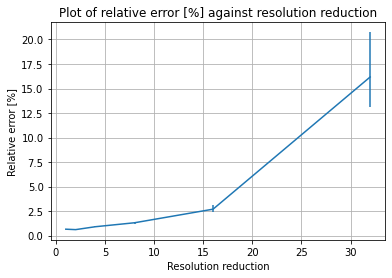

In [10]:
plt.figure()
plt.errorbar(df.down_res, df.mean_l2_error*100, yerr=[(df.mean_l2_error-df.min_l2_error)*100, (df.max_l2_error-df.mean_l2_error)*100], label='both limits (default)')
plt.title('Plot of relative error [%] against resolution reduction')
plt.grid()
plt.xlabel('Resolution reduction')
plt.ylabel('Relative error [%]')
plt.show()

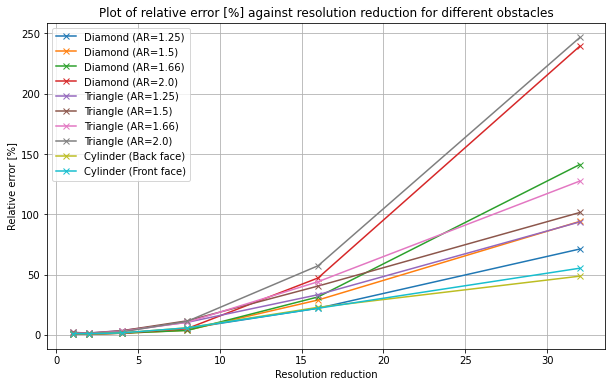

In [11]:
obstacle_dict = {
    "diamond_ar_1p25": 'Diamond (AR=1.25)',
    "diamond_ar_1p5": 'Diamond (AR=1.5)',
    "diamond_ar_1p66": 'Diamond (AR=1.66)',
    "diamond_ar_2p0": 'Diamond (AR=2.0)',
    "triangle_ar_1p25": 'Triangle (AR=1.25)',
    "triangle_ar_1p5": 'Triangle (AR=1.5)',
    "triangle_ar_1p66": 'Triangle (AR=1.66)',
    "triangle_ar_2p0": 'Triangle (AR=2.0)',
    "cylinder_half": 'Cylinder (Back face)',
    "cylinder_half_flipped": 'Cylinder (Front face)'
}


plt.figure(figsize=(10,6))
for obstacle in df_test.obstacle.unique():
    temp = df_test[df_test['obstacle']==obstacle].reset_index()
    plt.plot(temp.down_res[:6], temp['Mean L2 error [%]'][:6], 'x-', label=obstacle_dict[obstacle])

    
plt.legend()
plt.title('Plot of relative error [%] against resolution reduction for different obstacles')
plt.xlabel('Resolution reduction')
plt.ylabel('Relative error [%]')
plt.grid()

plt.show()

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)



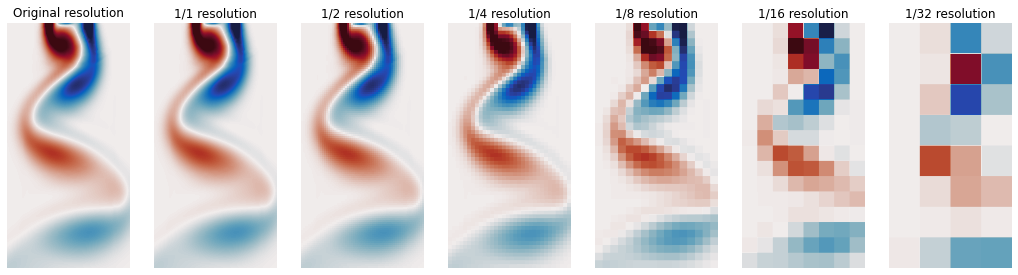

In [12]:
from utils import *
import tensorflow as tf
import cmocean

dataset_filepath = 'primitives/cylinder/w_z.npy'
y = load_data(dataset_filepath)
y = np.transpose(y, (0, 2, 1))
y = y[100:,:,:]
y = reshape_for_cnn(y)
y = y[:, 80:, :, :]
with tf.device('cpu:0'):
    y = resize_data(y)
    
down_res_arr = [1,2,4,8,16,32]
fig, axs = plt.subplots(1, len(down_res_arr)+1, figsize=(18,8))
minmax=np.max(np.abs(y[0,:,:,:])) * 0.65
axs[0].imshow(y[0,:,:,:], cmap=cmocean.cm.balance, vmin=-minmax, vmax=minmax)
axs[0].axis('off')
axs[0].set_title('Original resolution')
for idx, down_res in enumerate(down_res_arr):
    x = y[:, ::down_res, ::down_res, :].repeat(down_res, axis=1).repeat(down_res, axis=2)
    axs[idx+1].imshow(x[0,:,:,:], cmap=cmocean.cm.balance, vmin=-minmax, vmax=minmax)
    axs[idx+1].axis('off')
    axs[idx+1].set_title(f'1/{down_res} resolution')

In [13]:
# Reconstructing with CPU with GPU trained model

import json
import tensorflow as tf

save_folder_path = 'resolution_reduction_expanded_domain/experiment_6'

input_samples = []
actual_samples = []
prediction_samples = []
error_samples = []
l2_error_samples = []

with tf.device('cpu:0'):
    model_path = f'{save_folder_path}/model.h5'
    model = tf.keras.models.load_model(model_path)
    for obstacle in obstacles:
        dataset_filepath = f'primitives/{obstacle}/w_z.npy'
        y = load_data(dataset_filepath)
        y = np.transpose(y, (0, 2, 1))
        y = y[100:,:,:]
        y = reshape_for_cnn(y)
        y = y[:, 80:, :, :]
        y = resize_data(y)

        config_filepath = os.path.join(save_folder_path, 'config.json')
        config_data = json.load(open(config_filepath))
        down_res = config_data['sensor_parameters']['down_res']
        
        x = y[:, ::down_res, ::down_res, :].repeat(down_res, axis=1).repeat(down_res, axis=2)
        
        prediction = model.predict(x)
        
        img_per_pixel_abs_error = np.abs(prediction - y)
        img_overall_l2_error = calculate_l2_error_norm(prediction, y)
        
        max_error_sample = np.argmax(img_overall_l2_error)
        
        input_sample = x[max_error_sample,:,:]
        actual_sample = y[max_error_sample,:,:]
        prediction_sample = prediction[max_error_sample,:,:]
        error_sample = img_per_pixel_abs_error[max_error_sample, :, :]
        l2_error_sample = img_overall_l2_error[max_error_sample,0]
        
        input_samples.append(input_sample)
        actual_samples.append(actual_sample)
        prediction_samples.append(prediction_sample)
        error_samples.append(error_sample)
        l2_error_samples.append(l2_error_sample)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

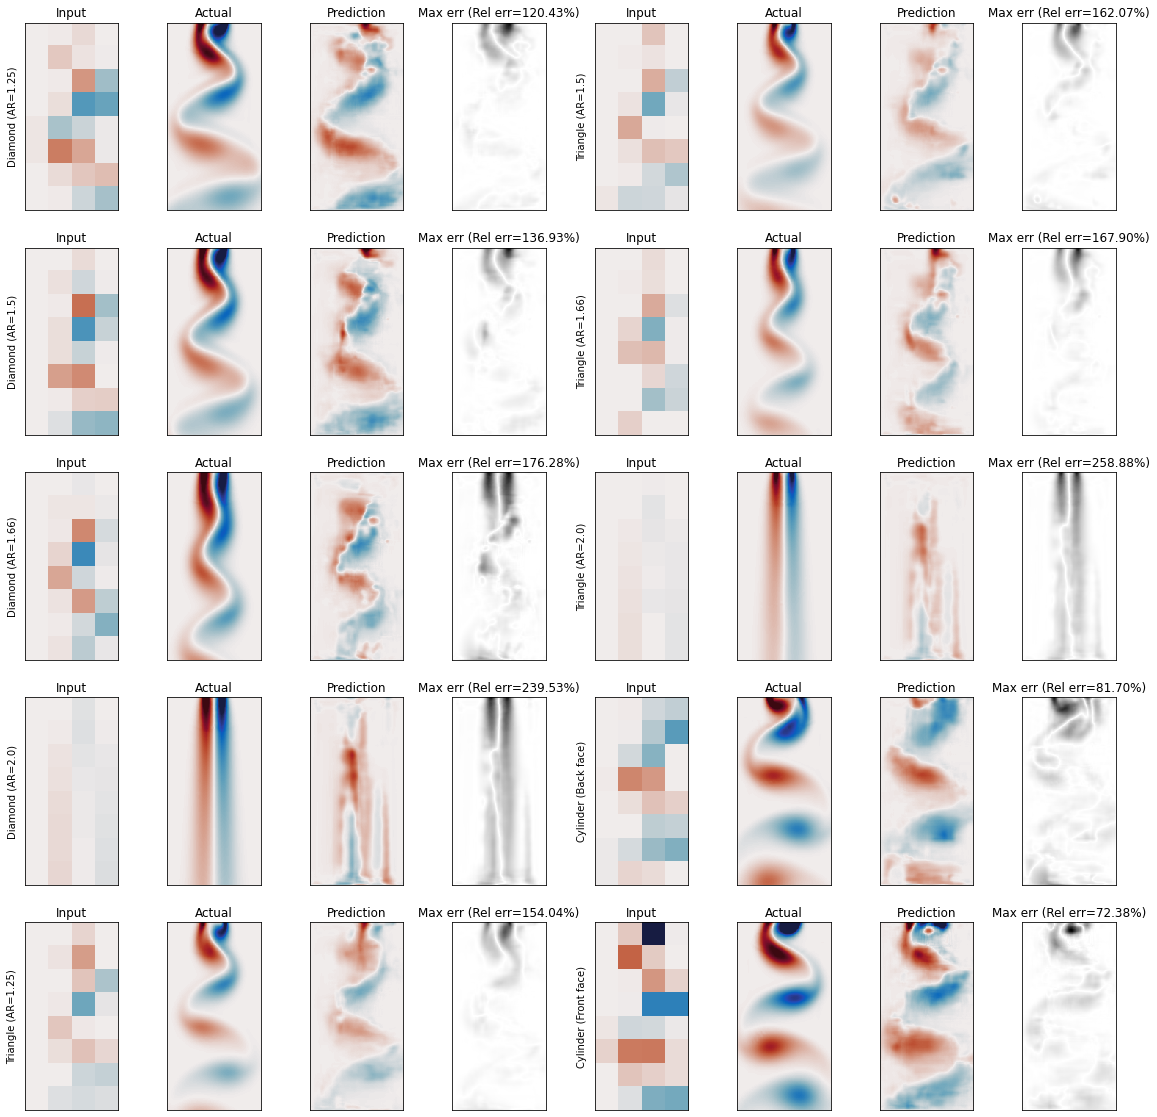

In [14]:
obstacle_dict = {
    "diamond_ar_1p25": 'Diamond (AR=1.25)',
    "diamond_ar_1p5": 'Diamond (AR=1.5)',
    "diamond_ar_1p66": 'Diamond (AR=1.66)',
    "diamond_ar_2p0": 'Diamond (AR=2.0)',
    "triangle_ar_1p25": 'Triangle (AR=1.25)',
    "triangle_ar_1p5": 'Triangle (AR=1.5)',
    "triangle_ar_1p66": 'Triangle (AR=1.66)',
    "triangle_ar_2p0": 'Triangle (AR=2.0)',
    "cylinder_half": 'Cylinder (Back face)',
    "cylinder_half_flipped": 'Cylinder (Front face)'
}

max_err = np.max(np.array(error_samples))

fig, axs = plt.subplots(5, 8, figsize=(20,20))
for idx, obstacle in enumerate(obstacles):
    col = idx // 5
    row = idx % 5
    minmax = np.max(np.abs(actual_samples[idx])) * 0.65
    axs[row, col*4].imshow(input_samples[idx], cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    axs[row, col*4].set_title('Input')
    axs[row, col*4+1].imshow(actual_samples[idx], cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    axs[row, col*4+1].set_title('Actual')
    axs[row, col*4+2].imshow(prediction_samples[idx], cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    axs[row, col*4+2].set_title('Prediction')
    axs[row, col*4+3].imshow(error_samples[idx], cmap='gray_r', interpolation='none', vmin=0, vmax=error_samples[idx].max())
    axs[row, col*4+3].set_title(f'Max err (Rel err={l2_error_samples[idx]*100:.2f}%)')
    for i in range(4):
        axs[row, col*4+i].tick_params(axis=u'both', which=u'both',length=0)
        axs[row, col*4+i].set_xticklabels([])
        axs[row, col*4+i].set_yticklabels([])
    axs[row, col*4].set_ylabel(obstacle_dict[obstacle])
    
plt.show()

# Expanded dataset
---

In [15]:
df_test_temp = df_test
df_temp = df

In [17]:
frames = []
interpolation_dirs = [1,2,3,4,5,6]

for interpolation_dir in interpolation_dirs:
    output_filepath = os.path.join(f'resolution_reduction_expanded_dataset/experiment_{interpolation_dir}', 'output.json')
    config_filepath = os.path.join(f'resolution_reduction_expanded_dataset/experiment_{interpolation_dir}', 'config.json')
    df = pd.read_json(output_filepath)
    df = df.drop(columns=['counter'])
    df = df.T
    config_data = json.load(open(config_filepath))
    df['down_res'] = config_data['sensor_parameters']['down_res']
    frames.append(df)
    
df = pd.concat(frames)
# cases = ['No scaling', 'Mean centring']
# df['case'] = cases
# df

In [18]:
df_val = df[['min_l2_error','max_l2_error','mean_l2_error', 'total_prediction_time', 'total_prediction_samples', 'total_training_time', 'total_epochs', 'down_res']].set_index(['down_res'])
df_val[['min_l2_error', 'max_l2_error', 'mean_l2_error']] *= 100
df_val['prediction_time_per_sample'] = df_val['total_prediction_time'] / df_val['total_prediction_samples'] * 1000
df_val['time_per_epoch'] = df_val['total_training_time'] / df_val['total_epochs']
df_val = df_val.fillna('-')

df_val = df_val.rename(columns={
    'min_l2_error':'Min L2 error [%]',
    'max_l2_error':'Max L2 error [%]',
    'mean_l2_error':'Mean L2 error [%]',
    'total_prediction_time':'Total prediction time [s]',
    'total_prediction_samples':'Total prediction samples',
    'prediction_time_per_sample':'Prediction time per sample [ms]',
    'total_training_time':'Total training time [s]',
    'total_epochs':'Total epochs',
    'time_per_epoch': 'Time per epoch [s]'
})
df_val

,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,Total training time [s],Total epochs,Prediction time per sample [ms],Time per epoch [s]
down_res,,,,,,,,,
1,0.551066,0.606466,0.578562,11.466117,320.0,4662.944489,311.0,35.831616,14.993391
2,0.682427,0.755764,0.724130,4.220953,320.0,3784.135214,255.0,13.190478,14.839746
4,0.937511,1.133512,1.007621,6.984908,320.0,4339.327590,294.0,21.827836,14.759618
8,3.238458,3.826085,3.540066,7.099848,320.0,4343.044339,291.0,22.187024,14.924551
16,3.264617,4.466128,3.785966,15.671570,320.0,4931.147425,330.0,48.973657,14.942871
32,11.688827,29.347014,16.845217,2.564561,320.0,5204.867538,350.0,8.014253,14.871050


In [19]:
obstacles = ["diamond_ar_1p25",
             "diamond_ar_1p5",
             "diamond_ar_1p66",
             "diamond_ar_2p0",
             "triangle_ar_1p25",
             "triangle_ar_1p5",
             "triangle_ar_1p66",
             "triangle_ar_2p0",
             "cylinder_half",
             "cylinder_half_flipped"]
frames_test = []
for obstacle in obstacles:
    df_test = df[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error',f'{obstacle}_total_prediction_time',f'{obstacle}_total_prediction_samples','down_res']].set_index(['down_res'])
    df_test[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error']] *= 100
    df_test[f'{obstacle}_prediction_time_per_sample'] = df_test[f'{obstacle}_total_prediction_time'] / df_test[f'{obstacle}_total_prediction_samples'] * 1000
    df_test = df_test.fillna('-')

    df_test = df_test.rename(columns={
        f'{obstacle}_min_l2_error':'Min L2 error [%]',
        f'{obstacle}_max_l2_error':'Max L2 error [%]',
        f'{obstacle}_mean_l2_error':'Mean L2 error [%]',
        f'{obstacle}_total_prediction_time':'Total prediction time [s]',
        f'{obstacle}_total_prediction_samples':'Total prediction samples',
        f'{obstacle}_prediction_time_per_sample':'Prediction time per sample [ms]',
    })
    df_test['obstacle'] = obstacle
    frames_test.append(df_test)

df_test = pd.concat(frames_test)
df_test_max = df_test.drop(columns=['obstacle']).groupby(level=[0]).max()
df_test_min = df_test.drop(columns=['obstacle']).groupby(level=[0]).min()

df_test_min_max = df_test_min.applymap(lambda x : [round(x,2)]) + df_test_max.applymap(lambda x : [round(x,2)])

df_test_min_max

,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,Prediction time per sample [ms]
down_res,,,,,,
1,"[0.47, 0.63]","[0.52, 0.66]","[0.5, 0.65]","[0.97, 2.73]","[400.0, 400.0]","[2.42, 6.82]"
2,"[0.56, 0.86]","[0.68, 0.93]","[0.63, 0.87]","[0.95, 1.61]","[400.0, 400.0]","[2.39, 4.03]"
4,"[0.96, 1.92]","[1.19, 2.51]","[1.04, 2.18]","[0.95, 1.47]","[400.0, 400.0]","[2.38, 3.68]"
8,"[3.56, 11.66]","[3.9, 17.4]","[3.71, 14.6]","[0.95, 1.58]","[400.0, 400.0]","[2.37, 3.96]"
16,"[10.67, 53.87]","[23.86, 53.93]","[16.95, 53.9]","[0.95, 1.48]","[400.0, 400.0]","[2.39, 3.7]"
32,"[25.9, 124.87]","[51.33, 154.05]","[33.97, 125.56]","[0.95, 1.57]","[400.0, 400.0]","[2.39, 3.93]"


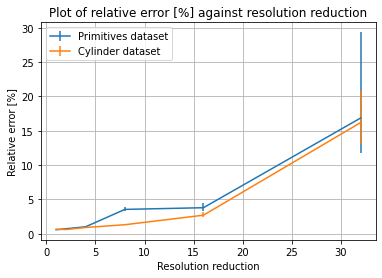

In [20]:
plt.figure()
plt.errorbar(df.down_res, df.mean_l2_error*100, yerr=[(df.mean_l2_error-df.min_l2_error)*100, (df.max_l2_error-df.mean_l2_error)*100], label='Primitives dataset')
plt.errorbar(df_temp.down_res, df_temp.mean_l2_error*100, yerr=[(df_temp.mean_l2_error-df_temp.min_l2_error)*100, (df_temp.max_l2_error-df_temp.mean_l2_error)*100], label='Cylinder dataset')
plt.title('Plot of relative error [%] against resolution reduction')
plt.grid()
plt.xlabel('Resolution reduction')
plt.ylabel('Relative error [%]')
plt.legend(loc='upper left')
plt.show()

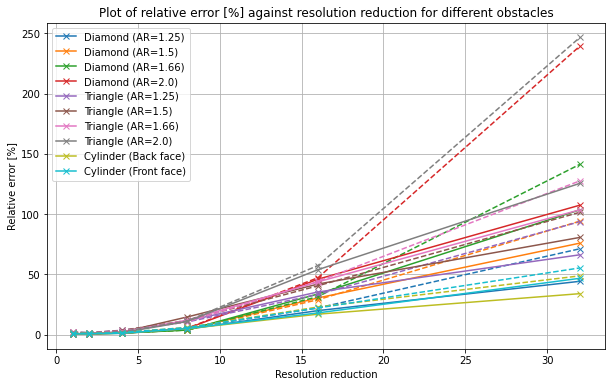

In [21]:
obstacle_dict = {
    "diamond_ar_1p25": 'Diamond (AR=1.25)',
    "diamond_ar_1p5": 'Diamond (AR=1.5)',
    "diamond_ar_1p66": 'Diamond (AR=1.66)',
    "diamond_ar_2p0": 'Diamond (AR=2.0)',
    "triangle_ar_1p25": 'Triangle (AR=1.25)',
    "triangle_ar_1p5": 'Triangle (AR=1.5)',
    "triangle_ar_1p66": 'Triangle (AR=1.66)',
    "triangle_ar_2p0": 'Triangle (AR=2.0)',
    "cylinder_half": 'Cylinder (Back face)',
    "cylinder_half_flipped": 'Cylinder (Front face)'
}


plt.figure(figsize=(10,6))
for obstacle in df_test.obstacle.unique():
    temp = df_test[df_test['obstacle']==obstacle].reset_index()
    temp_ = df_test_temp[df_test_temp['obstacle']==obstacle].reset_index()
    p = plt.plot(temp.down_res[:6], temp['Mean L2 error [%]'][:6], 'x-', label=obstacle_dict[obstacle])
    color = p[0].get_color()
    plt.plot(temp_.down_res[:6], temp_['Mean L2 error [%]'][:6], 'x--', label=None, color=color)

    
plt.legend()
plt.title('Plot of relative error [%] against resolution reduction for different obstacles')
plt.xlabel('Resolution reduction')
plt.ylabel('Relative error [%]')
plt.grid()

plt.show()

In [22]:
import json
import tensorflow as tf

save_folder_path = 'resolution_reduction_expanded_dataset/experiment_6'

input_samples = []
actual_samples = []
prediction_samples = []
error_samples = []
l2_error_samples = []

with tf.device('cpu:0'):
    model_path = f'{save_folder_path}/model.h5'
    model = tf.keras.models.load_model(model_path)
    for obstacle in obstacles:
        dataset_filepath = f'primitives/{obstacle}/w_z.npy'
        y = load_data(dataset_filepath)
        y = np.transpose(y, (0, 2, 1))
        y = y[100:,:,:]
        y = reshape_for_cnn(y)
        y = y[:, 80:, :, :]
        y = resize_data(y)

        config_filepath = os.path.join(save_folder_path, 'config.json')
        config_data = json.load(open(config_filepath))
        down_res = config_data['sensor_parameters']['down_res']
        
        x = y[:, ::down_res, ::down_res, :].repeat(down_res, axis=1).repeat(down_res, axis=2)
        
        prediction = model.predict(x)
        
        img_per_pixel_abs_error = np.abs(prediction - y)
        img_overall_l2_error = calculate_l2_error_norm(prediction, y)
        
        max_error_sample = np.argmax(img_overall_l2_error)
        
        input_sample = x[max_error_sample,:,:]
        actual_sample = y[max_error_sample,:,:]
        prediction_sample = prediction[max_error_sample,:,:]
        error_sample = img_per_pixel_abs_error[max_error_sample, :, :]
        l2_error_sample = img_overall_l2_error[max_error_sample,0]
        
        input_samples.append(input_sample)
        actual_samples.append(actual_sample)
        prediction_samples.append(prediction_sample)
        error_samples.append(error_sample)
        l2_error_samples.append(l2_error_sample)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

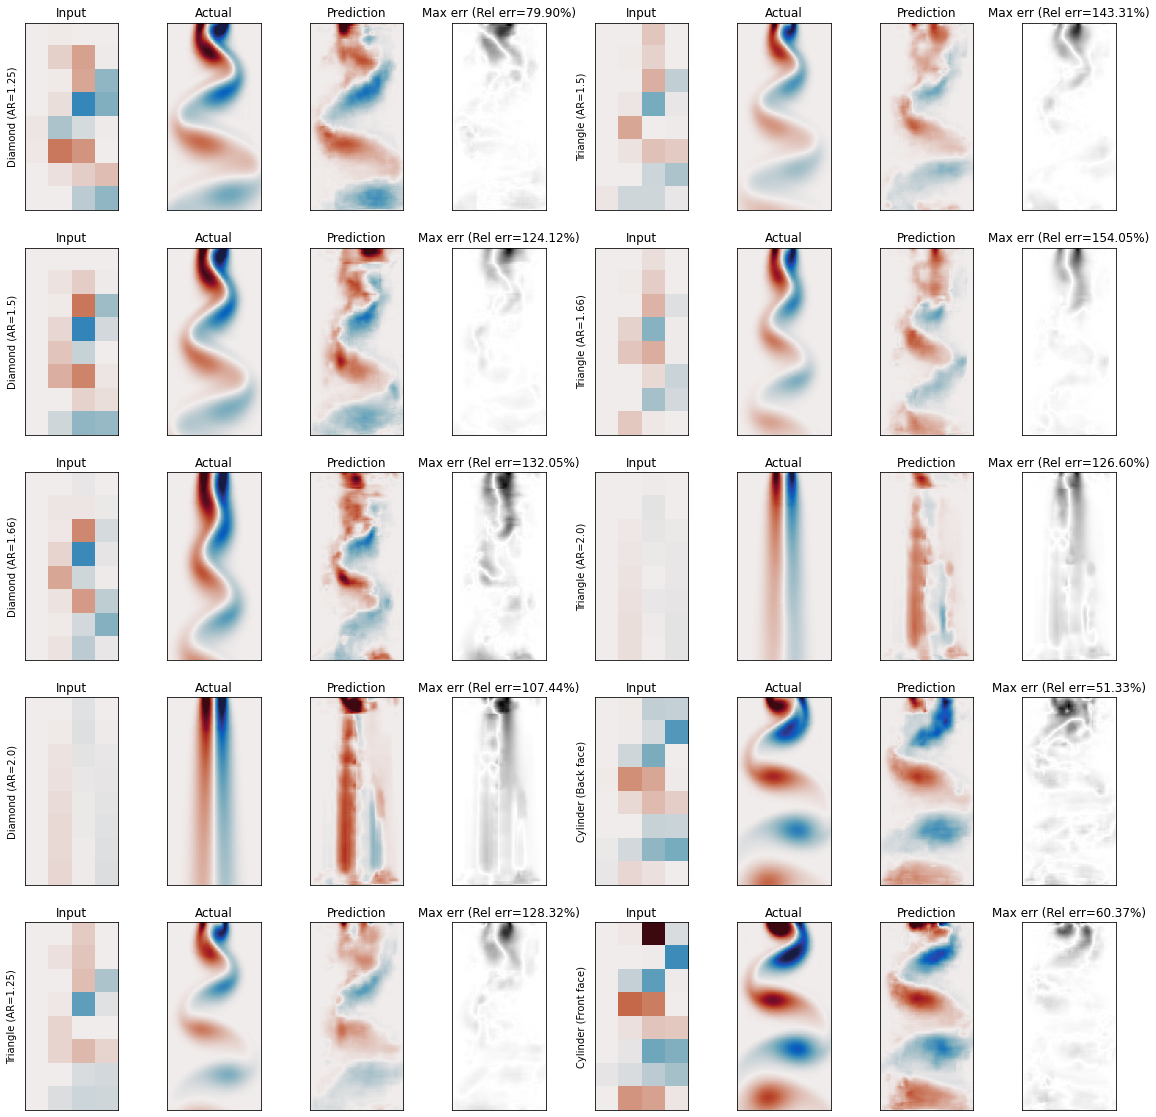

In [23]:
obstacle_dict = {
    "diamond_ar_1p25": 'Diamond (AR=1.25)',
    "diamond_ar_1p5": 'Diamond (AR=1.5)',
    "diamond_ar_1p66": 'Diamond (AR=1.66)',
    "diamond_ar_2p0": 'Diamond (AR=2.0)',
    "triangle_ar_1p25": 'Triangle (AR=1.25)',
    "triangle_ar_1p5": 'Triangle (AR=1.5)',
    "triangle_ar_1p66": 'Triangle (AR=1.66)',
    "triangle_ar_2p0": 'Triangle (AR=2.0)',
    "cylinder_half": 'Cylinder (Back face)',
    "cylinder_half_flipped": 'Cylinder (Front face)'
}

max_err = np.max(np.array(error_samples))

fig, axs = plt.subplots(5, 8, figsize=(20,20))
for idx, obstacle in enumerate(obstacles):
    col = idx // 5
    row = idx % 5
    minmax = np.max(np.abs(actual_samples[idx])) * 0.65
    axs[row, col*4].imshow(input_samples[idx], cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    axs[row, col*4].set_title('Input')
    axs[row, col*4+1].imshow(actual_samples[idx], cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    axs[row, col*4+1].set_title('Actual')
    axs[row, col*4+2].imshow(prediction_samples[idx], cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    axs[row, col*4+2].set_title('Prediction')
    axs[row, col*4+3].imshow(error_samples[idx], cmap='gray_r', interpolation='none', vmin=0, vmax=error_samples[idx].max())
    axs[row, col*4+3].set_title(f'Max err (Rel err={l2_error_samples[idx]*100:.2f}%)')
    for i in range(4):
        axs[row, col*4+i].tick_params(axis=u'both', which=u'both',length=0)
        axs[row, col*4+i].set_xticklabels([])
        axs[row, col*4+i].set_yticklabels([])
    axs[row, col*4].set_ylabel(obstacle_dict[obstacle])
    
plt.show()

# Model comparison
---

### interpolation vs cnn

In [25]:
frames = []
interpolation_dirs = [1,2,3,4,5,6,7,8,9]
# interpolation_dirs = [7,8,9,10,11,12,13,14,15]

for interpolation_dir in interpolation_dirs:
    output_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'output.json')
    config_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'config.json')
    df = pd.read_json(output_filepath)
    df = df.drop(columns=['counter'])
    df = df.T
    config_data = json.load(open(config_filepath))
    df['model_name'] = config_data['model_parameters']['model_name']
    df['model_method'] = config_data['model_parameters'].get('model_method','-')
    
    csv_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'training_epoch_data.csv')
    try:
        train_time = pd.read_csv(csv_filepath)
        train_time = train_time.times[1:].sum()
    except FileNotFoundError:
        train_time = np.nan
    
    df['total_training_time'] = train_time
    frames.append(df)
    
df = pd.concat(frames)
# df

In [26]:
df_val = df[['min_l2_error','max_l2_error','mean_l2_error', 'total_prediction_time', 'total_prediction_samples', 'total_training_time', 'total_epochs', 'model_name', 'model_method']].set_index(['model_name', 'model_method'])
df_val[['min_l2_error', 'max_l2_error', 'mean_l2_error']] *= 100
df_val['prediction_time_per_sample'] = df_val['total_prediction_time'] / df_val['total_prediction_samples'] * 1000
df_val['time_per_epoch'] = df_val['total_training_time'] / df_val['total_epochs']
df_val = df_val.fillna('-')

df_val = df_val.rename(columns={
    'min_l2_error':'Min L2 error [%]',
    'max_l2_error':'Max L2 error [%]',
    'mean_l2_error':'Mean L2 error [%]',
    'total_prediction_time':'Total prediction time [s]',
    'total_prediction_samples':'Total prediction samples',
    'prediction_time_per_sample':'Prediction time per sample [ms]',
    'total_training_time':'Total training time [s]',
    'total_epochs':'Total epochs',
    'time_per_epoch': 'Time per epoch [s]'
})
df_val

Min L2 error [%]  Max L2 error [%]  \
model_name    model_method                                       
interpolation bicubic              30.515772         37.822989   
              bilinear             30.781135         38.198888   
              lanczos3             30.985937         38.034427   
              lanczos5             31.146857         38.126799   
              gaussian             31.216159         38.460714   
              nearest              37.116897         43.501893   
srcnn         -                     2.843756          4.132057   
scnn          -                     1.618993          2.176266   
dsc_ms        -                     1.215837          1.381635   

                            Mean L2 error [%]  Total prediction time [s]  \
model_name    model_method                                                 
interpolation bicubic               34.463158                   0.020685   
              bilinear              34.728685                   0.011283   
              lanczos3              34.808168                   0.056364   
              lanczos5              34.933051                   0.062776   
              gaussian              35.040146                   0.039375   
              nearest               40.475154                   0.017792   
srcnn         -                      3.581393                   1.819882   
scnn          -                      1.922349                   0.127385   
dsc_ms        -                      1.291945                   3.190378   

                            Total prediction samples Total training time [s]  \
model_name    model_method                                                     
interpolation bicubic                           80.0                       -   
              bilinear                          80.0                       -   
              lanczos3                          80.0                       -   
              lanczos5                          80.0                       -   
              gaussian                          80.0                       -   
              nearest                           80.0                       -   
srcnn         -                                 80.0              961.472573   
scnn          -                                 80.0               48.320912   
dsc_ms        -                                 80.0             1523.323191   

                           Total epochs  Prediction time per sample [ms]  \
model_name    model_method                                                 
interpolation bicubic                 -                         0.258565   
              bilinear                -                         0.141034   
              lanczos3                -                         0.704551   
              lanczos5                -                         0.784701   
              gaussian                -                         0.492182   
              nearest                 -                         0.222403   
srcnn         -                   457.0                        22.748524   
scnn          -                   676.0                         1.592308   
dsc_ms        -                   414.0                        39.879727   

                           Time per epoch [s]  
model_name    model_method                     
interpolation bicubic                       -  
              bilinear                      -  
              lanczos3                      -  
              lanczos5                      -  
              gaussian                      -  
              nearest                       -  
srcnn         -                      2.103879  
scnn          -                      0.071481  
dsc_ms        -                      3.679525

In [27]:
obstacles = ["diamond_ar_1p25",
             "diamond_ar_1p5",
             "diamond_ar_1p66",
             "diamond_ar_2p0",
             "triangle_ar_1p25",
             "triangle_ar_1p5",
             "triangle_ar_1p66",
             "triangle_ar_2p0",
             "cylinder_half",
             "cylinder_half_flipped"]
frames_test = []
for obstacle in obstacles:
    df_test = df[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error',f'{obstacle}_total_prediction_time',f'{obstacle}_total_prediction_samples','model_name','model_method']].set_index(['model_name', 'model_method'])
    df_test[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error']] *= 100
    df_test[f'{obstacle}_prediction_time_per_sample'] = df_test[f'{obstacle}_total_prediction_time'] / df_test[f'{obstacle}_total_prediction_samples'] * 1000
    df_test = df_test.fillna('-')

    df_test = df_test.rename(columns={
        f'{obstacle}_min_l2_error':'Min L2 error [%]',
        f'{obstacle}_max_l2_error':'Max L2 error [%]',
        f'{obstacle}_mean_l2_error':'Mean L2 error [%]',
        f'{obstacle}_total_prediction_time':'Total prediction time [s]',
        f'{obstacle}_total_prediction_samples':'Total prediction samples',
        f'{obstacle}_prediction_time_per_sample':'Prediction time per sample [ms]',
    })
    frames_test.append(df_test)

df_test = pd.concat(frames_test)
df_test_max = df_test.groupby(level=[0,1]).max()
df_test_min = df_test.groupby(level=[0,1]).min()

df_test_min_max = df_test_min.applymap(lambda x : [round(x,2)]) + df_test_max.applymap(lambda x : [round(x,2)])

df_test_min_max

Min L2 error [%] Max L2 error [%]  \
model_name    model_method                                     
dsc_ms        -               [3.05, 12.41]     [3.4, 14.51]   
interpolation bicubic         [28.7, 43.39]   [37.95, 49.62]   
              bilinear        [29.0, 44.86]    [37.9, 50.94]   
              gaussian       [29.39, 46.04]   [37.95, 51.72]   
              lanczos3       [28.98, 43.79]     [38.2, 49.5]   
              lanczos5       [29.06, 44.57]    [38.3, 49.66]   
              nearest        [35.26, 50.88]    [43.2, 55.85]   
scnn          -               [4.23, 13.07]    [4.73, 16.91]   
srcnn         -               [3.93, 10.55]    [4.23, 16.22]   

                           Mean L2 error [%] Total prediction time [s]  \
model_name    model_method                                               
dsc_ms        -                [3.23, 12.42]              [0.95, 1.31]   
interpolation bicubic         [32.17, 45.11]                [0.1, 0.1]   
              bilinear        [32.26, 46.49]              [0.06, 0.06]   
              gaussian         [32.47, 47.5]               [0.18, 0.2]   
              lanczos3        [32.42, 45.69]              [0.23, 0.23]   
              lanczos5         [32.5, 46.49]              [0.31, 0.31]   
              nearest          [38.0, 53.04]              [0.06, 0.06]   
scnn          -                [4.45, 14.77]              [0.11, 0.12]   
srcnn         -                [4.22, 13.51]               [0.7, 0.73]   

                           Total prediction samples  \
model_name    model_method                            
dsc_ms        -                      [400.0, 400.0]   
interpolation bicubic                [400.0, 400.0]   
              bilinear               [400.0, 400.0]   
              gaussian               [400.0, 400.0]   
              lanczos3               [400.0, 400.0]   
              lanczos5               [400.0, 400.0]   
              nearest                [400.0, 400.0]   
scnn          -                      [400.0, 400.0]   
srcnn         -                      [400.0, 400.0]   

                           Prediction time per sample [ms]  
model_name    model_method                                  
dsc_ms        -                               [2.37, 3.29]  
interpolation bicubic                         [0.25, 0.25]  
              bilinear                        [0.15, 0.16]  
              gaussian                        [0.46, 0.49]  
              lanczos3                        [0.56, 0.58]  
              lanczos5                        [0.77, 0.77]  
              nearest                         [0.15, 0.15]  
scnn          -                               [0.28, 0.29]  
srcnn         -                               [1.75, 1.83]

### CNN modifications

In [28]:
frames = []
# interpolation_dirs = [1,2,3,4,5,6,7,8,9]
interpolation_dirs = [7,8,9,10,11,12,13,14,15]

for interpolation_dir in interpolation_dirs:
    output_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'output.json')
    config_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'config.json')
    df = pd.read_json(output_filepath)
    df = df.drop(columns=['counter'])
    df = df.T
    config_data = json.load(open(config_filepath))
    df['model_name'] = config_data['model_parameters']['model_name']
    df['model_method'] = config_data['model_parameters'].get('model_method','-')
    
    csv_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'training_epoch_data.csv')
    try:
        train_time = pd.read_csv(csv_filepath)
        train_time = train_time.times[1:].sum()
    except FileNotFoundError:
        train_time = np.nan
    
    df['total_training_time'] = train_time
    frames.append(df)
    
df = pd.concat(frames)
df = df.groupby('model_name').last().reset_index()
# df

In [29]:
df_val = df[['min_l2_error','max_l2_error','mean_l2_error', 'total_prediction_time', 'total_prediction_samples', 'total_training_time', 'total_epochs', 'model_name', 'model_method']].set_index(['model_name', 'model_method'])
df_val[['min_l2_error', 'max_l2_error', 'mean_l2_error']] *= 100
df_val['prediction_time_per_sample'] = df_val['total_prediction_time'] / df_val['total_prediction_samples'] * 1000
df_val['time_per_epoch'] = df_val['total_training_time'] / df_val['total_epochs']
df_val = df_val.fillna('-')

df_val = df_val.rename(columns={
    'min_l2_error':'Min L2 error [%]',
    'max_l2_error':'Max L2 error [%]',
    'mean_l2_error':'Mean L2 error [%]',
    'total_prediction_time':'Total prediction time [s]',
    'total_prediction_samples':'Total prediction samples',
    'prediction_time_per_sample':'Prediction time per sample [ms]',
    'total_training_time':'Total training time [s]',
    'total_epochs':'Total epochs',
    'time_per_epoch': 'Time per epoch [s]'
})
df_val

,,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,Total training time [s],Total epochs,Prediction time per sample [ms],Time per epoch [s]
model_name,model_method,,,,,,,,,
dsc_ms,-,1.215837,1.381635,1.291945,3.190378,80.0,1523.323191,414.0,39.879727,3.679525
dsc_ms_mod,-,2.256586,2.446575,2.342008,0.327533,80.0,1690.073017,456.0,4.094160,3.706300
dsc_ms_mod_custom_loss,-,1.494860,1.702564,1.594776,5.617918,80.0,1239.487701,336.0,70.223978,3.688951
dsc_ms_vgg_mod,-,1.579555,1.734649,1.644564,2.282082,80.0,1639.153418,313.0,28.526020,5.236912
scnn,-,1.618993,2.176266,1.922349,0.127385,80.0,48.320912,676.0,1.592308,0.071481
scnn_custom_loss,-,1.776343,2.365392,2.048401,0.151507,80.0,41.438557,619.0,1.893836,0.066944
scnn_sc_mod,-,1.392444,1.884499,1.611486,0.125001,80.0,58.723990,848.0,1.562509,0.069250
scnn_vgg_mod,-,2.094808,2.648218,2.385530,0.174568,80.0,35.172528,466.0,2.182099,0.075478
srcnn,-,2.843756,4.132057,3.581393,1.819882,80.0,961.472573,457.0,22.748524,2.103879


In [35]:
model_dict = {
    'dsc_ms': 'DSC/MS',
    'dsc_ms_mod': 'DSC/MS - bicubic',
    'dsc_ms_mod_custom_loss': 'DSC/MS - custom loss',
    'dsc_ms_vgg_mod': 'DSC/MS - VGG mod',
    'scnn': 'SCNN',
    'scnn_custom_loss': 'SCNN - custom loss',
    'scnn_sc_mod': 'SCNN - skip connection',
    'scnn_vgg_mod': 'SCNN - VGG mod',
    'srcnn': 'SRCNN'
}

df_latex = df[['model_name','min_l2_error','max_l2_error','mean_l2_error',
               'total_prediction_time','total_prediction_samples',
               'total_training_time','total_epochs']]
df_latex[['min_l2_error', 'max_l2_error', 'mean_l2_error']] *= 100
df_latex['prediction_time_per_sample'] = df_latex['total_prediction_time'] / df_latex['total_prediction_samples'] * 1000
df_latex['time_per_epoch'] = df_latex['total_training_time'] / df_latex['total_epochs']

banned_models = ['dsc_ms', 'scnn', 'srcnn']

for idx, row in df_latex.iterrows():
    if row.model_name not in banned_models:
        output = model_dict[row['model_name']]
        output += f' & {row["min_l2_error"]:.2f}\%'
        output += f' & {row["max_l2_error"]:.2f}\%'
        output += f' & {row["mean_l2_error"]:.2f}\%'
        output += f' & {row["total_training_time"]:.2f}'
        output += f' & {row["total_epochs"]:.0f}'
        output += f' & {row["time_per_epoch"]:.2f}'
        output += f' & {row["prediction_time_per_sample"]:.3f}'
        output += f' \\\\'
        print(output)

DSC/MS - bicubic & 2.26\% & 2.45\% & 2.34\% & 1690.07 & 456 & 3.71 & 4.094 \\
DSC/MS - custom loss & 1.49\% & 1.70\% & 1.59\% & 1239.49 & 336 & 3.69 & 70.224 \\
DSC/MS - VGG mod & 1.58\% & 1.73\% & 1.64\% & 1639.15 & 313 & 5.24 & 28.526 \\
SCNN - custom loss & 1.78\% & 2.37\% & 2.05\% & 41.44 & 619 & 0.07 & 1.894 \\
SCNN - skip connection & 1.39\% & 1.88\% & 1.61\% & 58.72 & 848 & 0.07 & 1.563 \\
SCNN - VGG mod & 2.09\% & 2.65\% & 2.39\% & 35.17 & 466 & 0.08 & 2.182 \\


/fsx/python_ml/venv/lib64/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/fsx/python_ml/venv/lib64/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
obstacles = ["diamond_ar_1p25",
             "diamond_ar_1p5",
             "diamond_ar_1p66",
             "diamond_ar_2p0",
             "triangle_ar_1p25",
             "triangle_ar_1p5",
             "triangle_ar_1p66",
             "triangle_ar_2p0",
             "cylinder_half",
             "cylinder_half_flipped"]
frames_test = []
for obstacle in obstacles:
    df_test = df[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error',f'{obstacle}_total_prediction_time',f'{obstacle}_total_prediction_samples','model_name','model_method']].set_index(['model_name', 'model_method'])
    df_test[[f'{obstacle}_min_l2_error',f'{obstacle}_max_l2_error',f'{obstacle}_mean_l2_error']] *= 100
    df_test[f'{obstacle}_prediction_time_per_sample'] = df_test[f'{obstacle}_total_prediction_time'] / df_test[f'{obstacle}_total_prediction_samples'] * 1000
    df_test = df_test.fillna('-')

    df_test = df_test.rename(columns={
        f'{obstacle}_min_l2_error':'Min L2 error [%]',
        f'{obstacle}_max_l2_error':'Max L2 error [%]',
        f'{obstacle}_mean_l2_error':'Mean L2 error [%]',
        f'{obstacle}_total_prediction_time':'Total prediction time [s]',
        f'{obstacle}_total_prediction_samples':'Total prediction samples',
        f'{obstacle}_prediction_time_per_sample':'Prediction time per sample [ms]',
    })
    frames_test.append(df_test)

df_test = pd.concat(frames_test)
df_test_max = df_test.groupby(level=[0,1]).max()
df_test_min = df_test.groupby(level=[0,1]).min()

df_test_min_max = df_test_min.applymap(lambda x : [round(x,2)]) + df_test_max.applymap(lambda x : [round(x,2)])

df_test_min_max

,,Min L2 error [%],Max L2 error [%],Mean L2 error [%],Total prediction time [s],Total prediction samples,Prediction time per sample [ms]
model_name,model_method,,,,,,
dsc_ms,-,"[3.05, 12.41]","[3.4, 14.51]","[3.23, 12.42]","[0.95, 1.31]","[400.0, 400.0]","[2.37, 3.29]"
dsc_ms_mod,-,"[3.5, 10.96]","[4.5, 14.38]","[4.05, 12.55]","[0.85, 0.93]","[400.0, 400.0]","[2.14, 2.32]"
dsc_ms_mod_custom_loss,-,"[3.04, 11.41]","[4.09, 14.86]","[3.93, 12.71]","[0.85, 0.94]","[400.0, 400.0]","[2.13, 2.36]"
dsc_ms_vgg_mod,-,"[3.65, 11.2]","[3.86, 15.21]","[3.76, 12.73]","[1.45, 1.53]","[400.0, 400.0]","[3.63, 3.82]"
scnn,-,"[4.23, 13.07]","[4.73, 16.91]","[4.45, 14.77]","[0.11, 0.12]","[400.0, 400.0]","[0.28, 0.29]"
scnn_custom_loss,-,"[4.05, 13.78]","[5.0, 17.94]","[4.52, 15.31]","[0.11, 0.12]","[400.0, 400.0]","[0.28, 0.29]"
scnn_sc_mod,-,"[3.4, 13.2]","[3.77, 16.24]","[3.54, 14.64]","[0.11, 0.12]","[400.0, 400.0]","[0.28, 0.29]"
scnn_vgg_mod,-,"[3.96, 15.09]","[4.51, 18.22]","[4.18, 16.37]","[0.11, 0.12]","[400.0, 400.0]","[0.28, 0.3]"
srcnn,-,"[3.93, 10.55]","[4.23, 16.22]","[4.22, 13.51]","[0.7, 0.73]","[400.0, 400.0]","[1.75, 1.83]"


In [37]:
df_latex = df_test_min_max.reset_index()[['model_name','Min L2 error [%]','Max L2 error [%]','Mean L2 error [%]']]

val_idx = [key for key in df_latex.keys() if key != 'model_name']

for idx, row in df_latex.iterrows():
    if row.model_name not in banned_models:
        output = model_dict[row['model_name']]
        for val_idx_ in val_idx:
            output += f' & {row[val_idx_][0]:.2f}\% - {row[val_idx_][1]:.2f}\%'
        output += f' \\\\'
        print(output)

DSC/MS - bicubic & 3.50\% - 10.96\% & 4.50\% - 14.38\% & 4.05\% - 12.55\% \\
DSC/MS - custom loss & 3.04\% - 11.41\% & 4.09\% - 14.86\% & 3.93\% - 12.71\% \\
DSC/MS - VGG mod & 3.65\% - 11.20\% & 3.86\% - 15.21\% & 3.76\% - 12.73\% \\
SCNN - custom loss & 4.05\% - 13.78\% & 5.00\% - 17.94\% & 4.52\% - 15.31\% \\
SCNN - skip connection & 3.40\% - 13.20\% & 3.77\% - 16.24\% & 3.54\% - 14.64\% \\
SCNN - VGG mod & 3.96\% - 15.09\% & 4.51\% - 18.22\% & 4.18\% - 16.37\% \\


In [38]:
import json
import tensorflow as tf
from models import *

down_res = 8

input_samples = []
actual_samples = []
prediction_samples = []
error_samples = []
l2_error_samples = []

methods = ['nearest', 'bicubic', 'bilinear', 'lanczos3', 'lanczos5']
experiments = [7,8,9]

with tf.device('cpu:0'):
    dataset_filepath = f'primitives/cylinder/w_z.npy'
    y = load_data(dataset_filepath)
    y = np.transpose(y, (0, 2, 1))
    y = y[100:,:,:]
    y = reshape_for_cnn(y)
    y = y[:, 80:, :, :]
    y = resize_data(y)

    x = y[:, ::down_res, ::down_res, :]
    
    for method in methods:
        prediction = interpolation(x, down_res,  method)
        img_per_pixel_abs_error = np.abs(prediction - y)
        img_overall_l2_error = calculate_l2_error_norm(prediction, y)
        
        max_error_sample = 0
        
        input_sample = x[max_error_sample,:,:]
        actual_sample = y[max_error_sample,:,:]
        prediction_sample = prediction[max_error_sample,:,:]
        error_sample = img_per_pixel_abs_error[max_error_sample, :, :]
        l2_error_sample = img_overall_l2_error[max_error_sample,0]
        
        input_samples.append(input_sample)
        actual_samples.append(actual_sample)
        prediction_samples.append(prediction_sample)
        error_samples.append(error_sample)
        l2_error_samples.append(l2_error_sample)
    
    for experiment in experiments:
        if experiment != 9:
            x = y[:, ::down_res, ::down_res, :]
        else:
            x = y[:, ::down_res, ::down_res, :].repeat(down_res, axis=1).repeat(down_res, axis=2)

        model_path = f'model_comparison/experiment_{experiment}/model.h5'
        model = tf.keras.models.load_model(model_path)
        prediction = model.predict(x)
        
        img_per_pixel_abs_error = np.abs(prediction - y)
        img_overall_l2_error = calculate_l2_error_norm(prediction, y)
        
        max_error_sample = 0
        
        input_sample = x[max_error_sample,:,:]
        actual_sample = y[max_error_sample,:,:]
        prediction_sample = prediction[max_error_sample,:,:]
        error_sample = img_per_pixel_abs_error[max_error_sample, :, :]
        l2_error_sample = img_overall_l2_error[max_error_sample,0]
        
        input_samples.append(input_sample)
        actual_samples.append(actual_sample)
        prediction_samples.append(prediction_sample)
        error_samples.append(error_sample)
        l2_error_samples.append(l2_error_sample)

The shape of the data (t, m, n) is (500, 200, 500)
Resized data details:
    original data has shape (400, 420, 200, 1)
    resized data has shape (400, 256, 128, 1)

Bicubic model
    Method: nearest
    Original size of: (32, 16)
    Target size of: [256, 128]
Bicubic model
    Method: bicubic
    Original size of: (32, 16)
    Target size of: [256, 128]
Bicubic model
    Method: bilinear
    Original size of: (32, 16)
    Target size of: [256, 128]
Bicubic model
    Method: lanczos3
    Original size of: (32, 16)
    Target size of: [256, 128]
Bicubic model
    Method: lanczos5
    Original size of: (32, 16)
    Target size of: [256, 128]


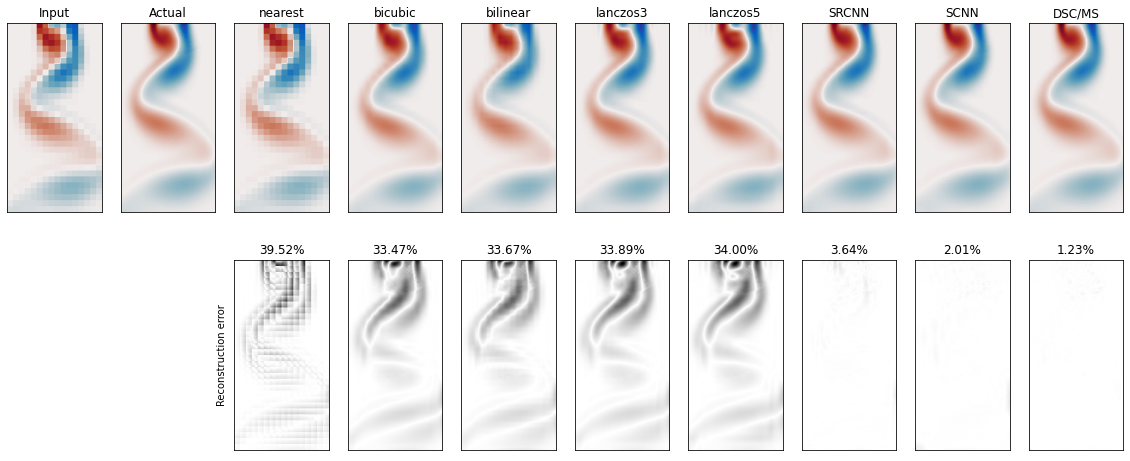

In [39]:
minmax = np.max(np.abs(y[0,:,:,:]))
models = ['SRCNN', 'SCNN', 'DSC/MS']

fig, axs = plt.subplots(2,len(methods)+len(models)+2,figsize=(20,8))

axs[0,0].imshow(x[0,:,:,:], cmap=cmocean.cm.balance, vmin=-minmax, vmax=minmax)
axs[0,0].set_title('Input')
axs[0,1].imshow(y[0,:,:,:], cmap=cmocean.cm.balance, vmin=-minmax, vmax=minmax)
axs[0,1].set_title('Actual')
axs[1,0].axis('off')
axs[1,1].axis('off')

for idx, method in enumerate(methods):
    axs[0,idx+2].imshow(prediction_samples[idx], cmap=cmocean.cm.balance, vmin=-minmax, vmax=minmax)
    axs[0,idx+2].set_title(method)
    axs[1,idx+2].imshow(error_samples[idx], cmap='gray_r', vmin=0, vmax=error_samples[idx].max())
    axs[1,idx+2].set_title(f'{l2_error_samples[idx]*100:.2f}%')
        
for idx, model in enumerate(models):
    axs[0,idx+2+len(methods)].imshow(prediction_samples[idx+len(methods)], cmap=cmocean.cm.balance, vmin=-minmax, vmax=minmax)
    axs[0,idx+2+len(methods)].set_title(model)
    axs[1,idx+2+len(methods)].imshow(error_samples[idx+len(methods)], cmap='gray_r', vmin=0, vmax=error_samples[idx].max())
    axs[1,idx+2+len(methods)].set_title(f'{l2_error_samples[idx+len(methods)]*100:.2f}%')

for i in range(len(methods)+len(models)+2):
    axs[0,i].tick_params(axis=u'both', which=u'both',length=0)
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
    axs[1,i].tick_params(axis=u'both', which=u'both',length=0)
    axs[1,i].set_xticklabels([])
    axs[1,i].set_yticklabels([])
    
axs[1,2].set_ylabel('Reconstruction error')
    
plt.show()

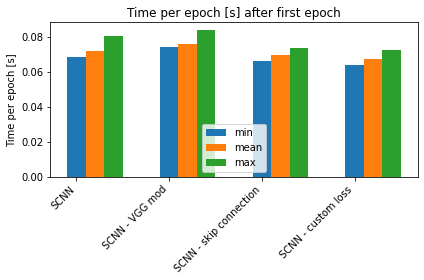

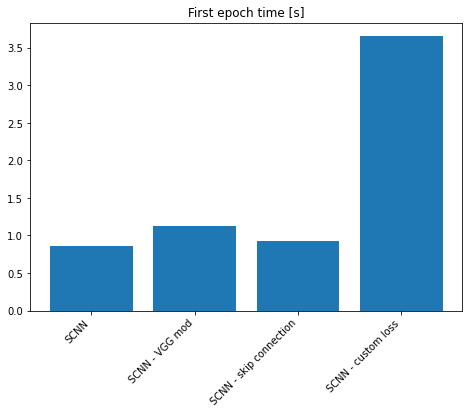

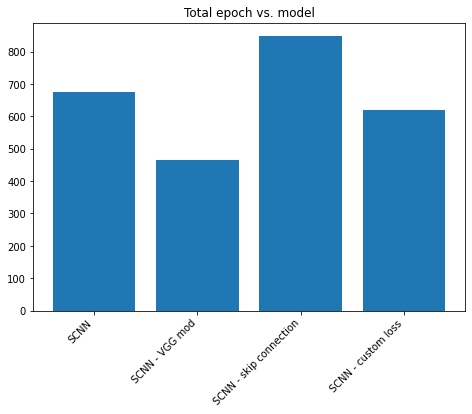

In [40]:
interpolation_dirs = [9, 10, 12, 15] # dsc/ms
interpolation_dirs = [8, 11, 13, 14] # scnn

model_dict = {
    'dsc_ms': 'DSC/MS',
    'dsc_ms_mod': 'DSC/MS - bicubic',
    'dsc_ms_mod_custom_loss': 'DSC/MS - custom loss',
    'dsc_ms_vgg_mod': 'DSC/MS - VGG mod',
    'scnn': 'SCNN',
    'scnn_custom_loss': 'SCNN - custom loss',
    'scnn_sc_mod': 'SCNN - skip connection',
    'scnn_vgg_mod': 'SCNN - VGG mod',
    'srcnn': 'SRCNN'
}


labels = []
mins = []
maxs = []
means = []
firsts = []
totals = []

for interpolation_dir in interpolation_dirs:
    config_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'config.json')
    config_data = json.load(open(config_filepath))
    csv_filepath = os.path.join(f'model_comparison/experiment_{interpolation_dir}', 'training_epoch_data.csv')
    training_df = pd.read_csv(csv_filepath)

    labels.append(model_dict[config_data['model_parameters']['model_name']])
    mins.append(training_df.times[1:].min())
    maxs.append(training_df.times[1:].max())
    means.append(training_df.times[1:].mean())
    firsts.append(training_df.times[0])
    totals.append(len(training_df))
    

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x + width*0, mins, width, label='min')
rects2 = ax.bar(x + width*1, means, width, label='mean')
rects1 = ax.bar(x + width*2, maxs, width, label='max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time per epoch [s]')
ax.set_title('Time per epoch [s] after first epoch')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.legend()

fig.tight_layout()
plt.show()


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,firsts)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
ax.set_title('First epoch time [s]')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,totals)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
ax.set_title('Total epoch vs. model')
plt.show()